# Autoencoders and multi-stage training for MNIST classification

In [this blog post](https://blog.keras.io/building-autoencoders-in-keras.html), [Francois Chollet](https://twitter.com/fchollet) demonstrates how to build several different variations of image auto-encoders
in Keras.

We build on the example above using `timeserio`'s `multinetwork`, and demonstrate some key features:

- we add a digit classifier that uses pre-trained encodings
- we encapsulate a neural network with multiple inter-connected parts using `MultiNetworkBase`
- we show how to implement multi-stage training with layer freezing
- we show how to add training callbacks and inspect multi-stage training history

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Load and normalize data

In [2]:
def to_onehot(y, num_classes=10):
    """Convert numpy array to one-hot."""
    onehot = np.zeros((len(y), num_classes))
    onehot[np.arange(len(y)), y] = 1
    return onehot

In [3]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

y_train_oh = to_onehot(y_train)
y_test_oh = to_onehot(y_test)

Using TensorFlow backend.


In [4]:
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape, y_train_oh.shape, y_test_oh.shape)

(60000, 28, 28) (10000, 28, 28) (60000,) (10000,) (60000, 10) (10000, 10)


In [5]:
def plot_images(x, y=None):
    """Plot all images in x, with optional labels given by y.
    
    Expect x.shape == (n, h, w), where n = number images, h = image height, w = image width
    """
    plt.figure(figsize=(20, 4))
    n = x.shape[0]
    for i in range(n):
        image = x[i]
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x[i])
        plt.gray()
        if y is not None:
            label = y[i]
            plt.title(label)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

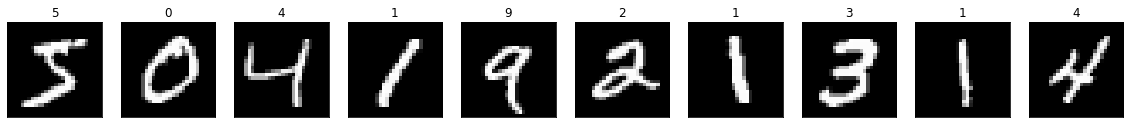

In [6]:
plot_images(x_train[:10], y_train[:10])

## Define network architectures

We follow the above blog post closely, but demonstrate some of the convenient features of `timeserio`.
In addition to the encoder-decoder, we add a classification model with softmax output that can be used either with image encodings,
or combined with the encoder for a full image classification pipeline:

![](img/MNIST.svg)

In [7]:
from timeserio.keras.multinetwork import MultiNetworkBase

from keras.layers import Input, Dense, Flatten, Reshape
from keras.models import Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

In [11]:
class AutoEncoderNetwork(MultiNetworkBase):
    def _model(self, image_side=28, encoding_dim=32, classifier_units=32, num_classes=10):
        """Define model architectures."""
        image_shape = (image_side, image_side)
        flat_shape = image_shape[0] * image_shape[1]

        input_img = Input(shape=image_shape, name="input_image")
        encoded = Dense(encoding_dim, activation='tanh')(Flatten()(input_img))
        encoder_model = Model(input_img, encoded, name="encoder")
        
        input_encoded = Input(shape=(encoding_dim,), name="input_encoding")
        decoded = Reshape(image_shape)(Dense(flat_shape, activation='sigmoid')(input_encoded))
        decoder_model = Model(input_encoded, decoded, name="decoder")
        
        autoencoder_model = Model(input_img, decoder_model(encoder_model(input_img)))
        autoencoder_model.compile(optimizer='adam', loss='binary_crossentropy')
        
        clf_intermediate = Dense(classifier_units, activation='relu')(input_encoded)
        clf = Dense(num_classes, activation='softmax')(clf_intermediate)
        # this model classifies encoding vectors
        encoding_clf_model = Model(input_encoded, clf, name="encoder_classifier")
        
        # this model classifies images
        classifier_model = Model(input_img, encoding_clf_model(encoder_model(input_img)), name="image_classifier")
        classifier_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

        return {
            'encoder': encoder_model,
            'decoder': decoder_model,
            'autoencoder': autoencoder_model,
            'encoding_classifier': encoding_clf_model,  # we expose this model to allow granular freezing/un-freezing
            'classifier': classifier_model,
        }
    
    def _callbacks(
            self,
            *,
            es_params={
                'patience': 20,
                'monitor': 'val_loss'
            },
            lr_params={
                'monitor': 'val_loss',
                'patience': 4,
                'factor': 0.2
            }
    ):
        """Define optional callbacks for each model."""
        early_stopping = EarlyStopping(**es_params)
        learning_rate_reduction = ReduceLROnPlateau(**lr_params)
        return {
            'autoencoder': [early_stopping, learning_rate_reduction],
            'classifier': [early_stopping, learning_rate_reduction],
        }


In [12]:
multinetwork = AutoEncoderNetwork(encoding_dim=32)

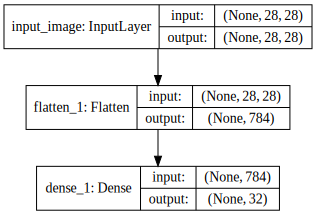

In [14]:
SVG(model_to_dot(multinetwork.model['encoder'], show_shapes=True).create(prog='dot', format='svg'))

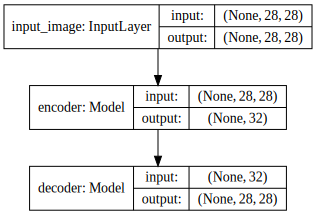

In [15]:
SVG(model_to_dot(multinetwork.model['autoencoder'], show_shapes=True).create(prog='dot', format='svg'))

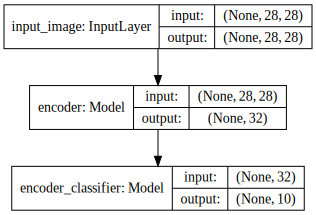

In [16]:
SVG(model_to_dot(multinetwork.model['classifier'], show_shapes=True).create(prog='dot', format='svg'))

## Train autoencoder

We see that using `adam` optimizer gives us a better loss compared to `adadelta`, even for a shallow auto-encoder

In [ ]:
multinetwork.fit(
    x_train, x_train,
    model='autoencoder',
    reset_weights=True,
    epochs=100,
    batch_size=2 ** 8,
    shuffle=True,
    validation_data=(x_test, x_test),
    verbose=1,
)

Training history is stored in the `multinetwork.history` list. Every time we call `fit`, a new history record is appended.
This allows us to track training history over multiple pre-/post-training runs.
History includes information such as learning rate (`lr`) and time duration per epoch.

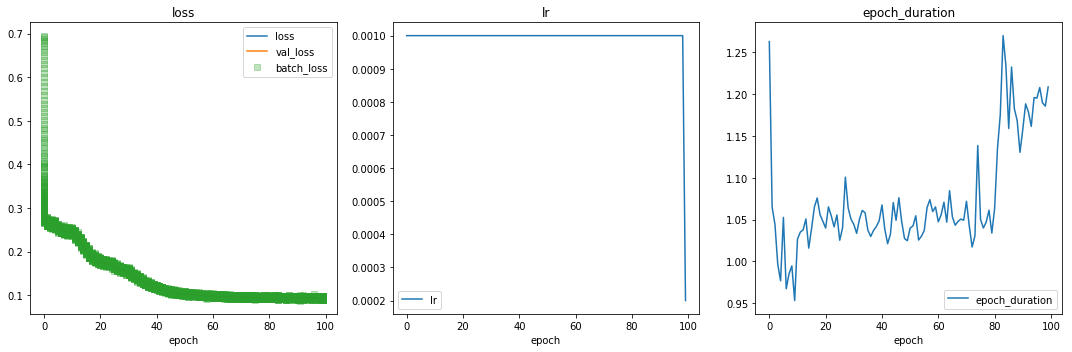

array([<matplotlib.axes._subplots.AxesSubplot object at 0x14ab8a9e8>,
      dtype=object)

In [18]:
from kerashistoryplot.plot import plot_history

h = multinetwork.history[-1]["history"]
plot_history(h, batches=True, n_cols=3, figsize=(15,5))

### Encode and decode some digits
Sweet, eh?

In [19]:
encoded_imgs = multinetwork.predict(x_test, model='encoder')
decoded_imgs = multinetwork.predict(encoded_imgs, model='decoder')

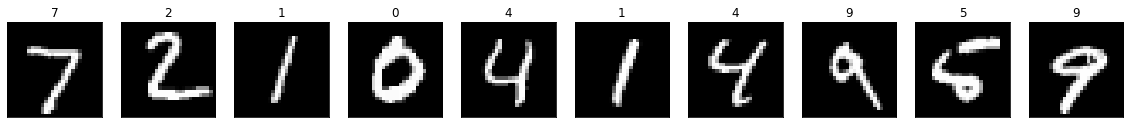

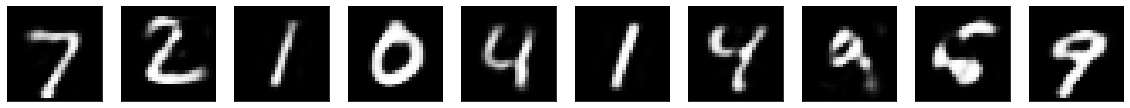

In [20]:
plot_images(x_test[:10], y_test[:10])
plot_images(decoded_imgs[:10])

### Visualize encodings
We use simple PCA to visualize 32-dimensional embeddings in 2D.

In [21]:
from sklearn.decomposition import PCA

In [22]:
encoded_imgs_2D = PCA(n_components=2).fit_transform(encoded_imgs)

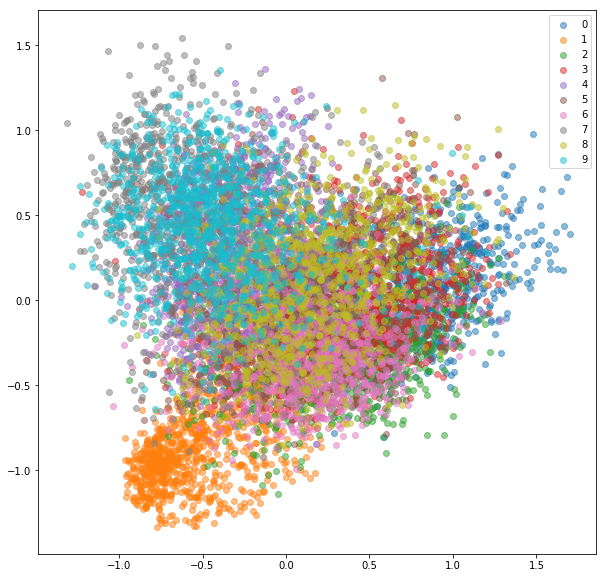

In [23]:
plt.figure(figsize=(10, 10))
for label in range(10):
    encodings = encoded_imgs_2D[y_test == label, :]
    plt.scatter(encodings[:, 0], encodings[:, 1], alpha=.5, label=label)
plt.legend()

## Fit classifier model
Using the pre-trained encoder, we can fit a classification model by training the dense layers of the `encoding_classifier` model only.

In [ ]:
multinetwork.fit(
    x_train, y_train_oh,
    model='classifier',  # this is the compiled model we use to perform gradient descent
    trainable_models=['encoding_classifier'],  # only the layers in this model will be un-frozen
    epochs=100,
    batch_size=2 ** 8,
    shuffle=True,
    validation_data=(x_test, y_test_oh),
    verbose=1,
)

### Training history
Note that `multinetwork.history` now contains two records: one for the autoencoder pre-training, and one for post-training the dense layers.
By freezing the encoder, we also speed up classifier post-training significantly.

In [25]:
pre_training = multinetwork.history[0]
print(f"Training model: {pre_training['model']}, trainable: {pre_training['trainable_models']}")

Training model: autoencoder, trainable: ['encoder', 'decoder', 'autoencoder', 'encoding_classifier', 'classifier']


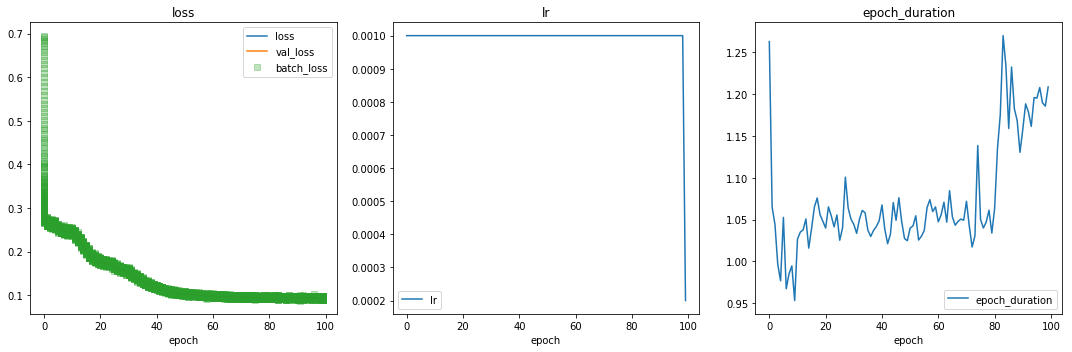

array([<matplotlib.axes._subplots.AxesSubplot object at 0x14de17208>,
      dtype=object)

In [26]:
plot_history(pre_training["history"], batches=True, n_cols=3, figsize=(15,5))

In [27]:
post_training = multinetwork.history[1]
print(f"Training model: {post_training['model']}, trainable: {post_training['trainable_models']}")

Training model: classifier, trainable: ['encoding_classifier']


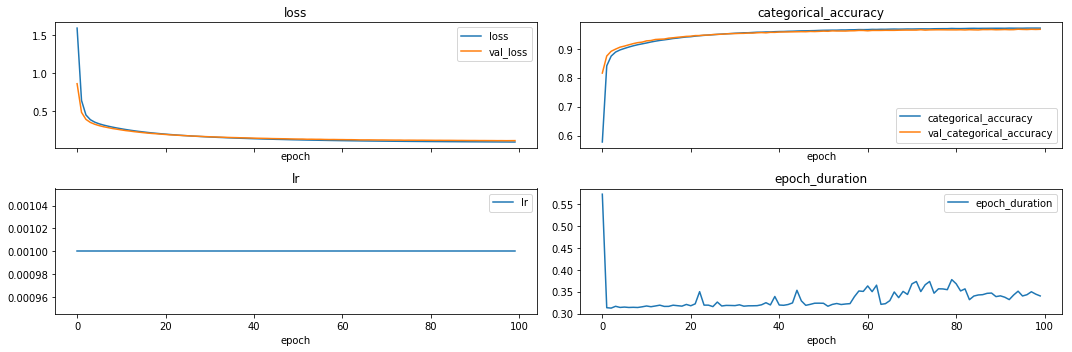

In [28]:
plot_history(post_training["history"], batches=False, n_cols=2, figsize=(15,5))

### Final classifier score
Our classifier performance is not ground-breaking, but our example show a simple way to implement multi-stage training using a `multinetwork`.

In [29]:
loss, acc = multinetwork.evaluate(x_test, y_test_oh, model='classifier')
print(f"Loss: {loss:.3f}, accuracy: {acc:.3f}")

Loss: 0.113, accuracy: 0.967


### Some examples
We plot original images from the test set with their true labels on top, and decoded images with classifier labels on the bottom.

In [30]:
y_test_pred_oh = multinetwork.predict(x_test, model='classifier')
y_test_pred = np.argmax(y_test_pred_oh, axis=1)

In [34]:
n = 20
idx = np.random.choice(len(x_test), size=n, replace=False)

True labels: 


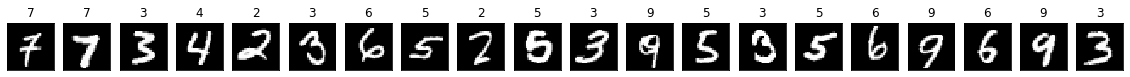

Predicted labels: 


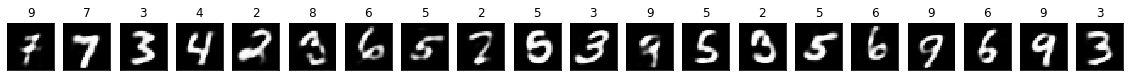

In [35]:
print("True labels: ")
plot_images(x_test[idx], y_test[idx])
print("Predicted labels: ")
plot_images(decoded_imgs[idx], y_test_pred[idx])